This notebook is a tutorial for computing SEACell metacells, visualizing results and computing evaluation metrics

# Imports

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
import SEACells

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [3]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [8, 8]
matplotlib.rcParams['figure.dpi'] = 100


# Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample datset is available for download with the instructions listed below. This is a filtered, unnormalized counts of single-nuclear RNA-seq dataset of CD34+ sorted bone marrow cells to profile human hematopoiesis [Dataset ref TBD].

Uncomment the following lines to download the sample dataset in a Unix-based system. For non-UNIX systems, download the files using the URL

In [5]:
# !mkdir data/
# !wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_rna.h5ad -O data/cd34_multiome_rna.h5ad 

In [6]:
# Load the data using 
ad = sc.read_h5ad('/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/gpu_trained_20_dim/anndata_object')

In [32]:
atac = sc.read_h5ad("/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/anndata_atac_peak_matrix.h5ad")
atac

AnnData object with n_obs × n_vars = 45991 × 180499
    obs: 'BlacklistRatio', 'nDiFrags', 'nFrags', 'nMonoFrags', 'nMultiFrags', 'NucleosomeRatio', 'PassQC', 'PromoterRatio', 'ReadsInBlacklist', 'ReadsInPromoter', 'ReadsInTSS', 'Sample', 'TSSEnrichment', 'barcode', 'sample', 'nFeature_RNA', 'nCount_RNA', 'mitochondrial_percent_RNA', 'ribosomal_percent_RNA', 'stage', 'pass_rnaQC', 'doublet_score', 'doublet_call', 'celltype.mapped_mnn', 'celltype.score_mnn', 'closest.cell', 'celltype.mapped_seurat', 'celltype.score_seurat', 'TSSEnrichment_atac', 'ReadsInTSS_atac', 'PromoterRatio_atac', 'NucleosomeRatio_atac', 'nFrags_atac', 'BlacklistRatio_atac', 'ReadsInPeaks', 'FRIP'
    var: 'chr', 'start', 'end', 'score', 'idx'

In [14]:
# Plot cell-types for reference
#sc.pl.scatter(ad, basis='umap', color='celltype', frameon=False)

In [21]:
ad

AnnData object with n_obs × n_vars = 45991 × 5000
    obs: 'sample', 'stage', 'nFeature_RNA', 'mitochondrial_percent_RNA', 'ribosomal_percent_RNA', 'celltype', '_scvi_batch', '_scvi_labels', 'n_counts'
    var: 'gene', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_scVI', '_scvi_extra_categorical_covs', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connectivities'

# Pre-processing

The following section describes basic pre-processing steps for scRNA-seq. For scATAC-seq, we provide a pipeline for pre-processing in  in example notebook `preprocessing-ATAC.ipynb`

In [8]:
# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_ad = sc.AnnData(ad.X)
raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
ad.raw = raw_ad

In [9]:
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=2000)

In [10]:
# Compute principal components - 
# Here we use 50 components. This number may also be selected by examining variance explaint
sc.tl.pca(ad, n_comps=50, use_highly_variable=True)

In [11]:
# compute the k-nearest-neighbor graph that is used in both clustering and umap algorithms
sc.pp.neighbors(ad, use_rep="X_scVI")
# compute the umap
sc.tl.umap(ad, min_dist=0.2)

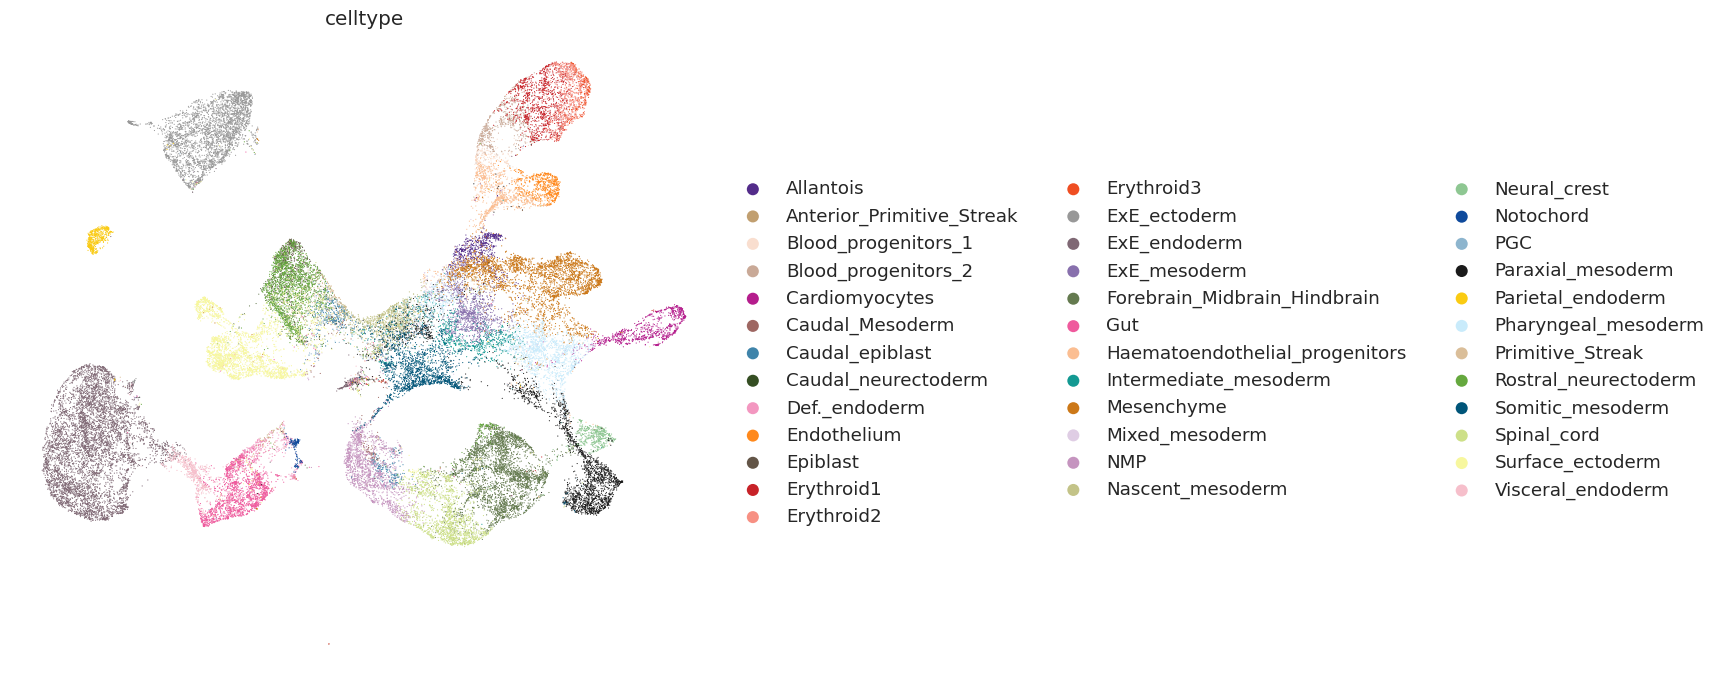

In [12]:
# Plot cell-types for reference
sc.pl.scatter(ad, basis='umap', color='celltype', frameon=False)

# Running SEACells

As a rule of thumb, we recommended choosing one metacell for every 75 single-cells. Since this dataset contains ~7k cells, we choose 90 metacells.

<b>Note 1: </b> Running SEACells modifies the input Anndata object and adds the SEACell metacell assignments to the `obs` dataframe in the anndata object.
<b>Note 2: </b> This analysis takes approxmiately 5 minutes

The number of cells is a hyperparameter. You should examine the initializtation to ensure that cell states span the entirety of the phenotypic manifold.

In [ ]:
np.round(45991/75)

In [17]:
## User defined parameters

## Core parameters 
# since we have 45991 cells in our dataset, we will 
#n_SEACells = 613
n_SEACells = 1500

build_kernel_on = 'X_scVI' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells
waypoint_proportion = 0.9 # Proportion of metacells to initialize using waypoint analysis, 
                        # the remainder of cells are selected by greedy selection

In [18]:
model = SEACells.core.SEACells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  waypt_proportion=waypoint_proportion,
                  convergence_epsilon = 1e-5)

Building kernel...
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/45991 [00:00<?, ?it/s]

Making graph symmetric...
Computing RBF kernel...


  0%|          | 0/45991 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/45991 [00:00<?, ?it/s]

Constructing CSR matrix...


In [19]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_scVI
Computing diffusion components from X_scVI for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 1304 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


  0%|          | 0/206 [00:00<?, ?it/s]

Selecting 196 cells from greedy initialization.


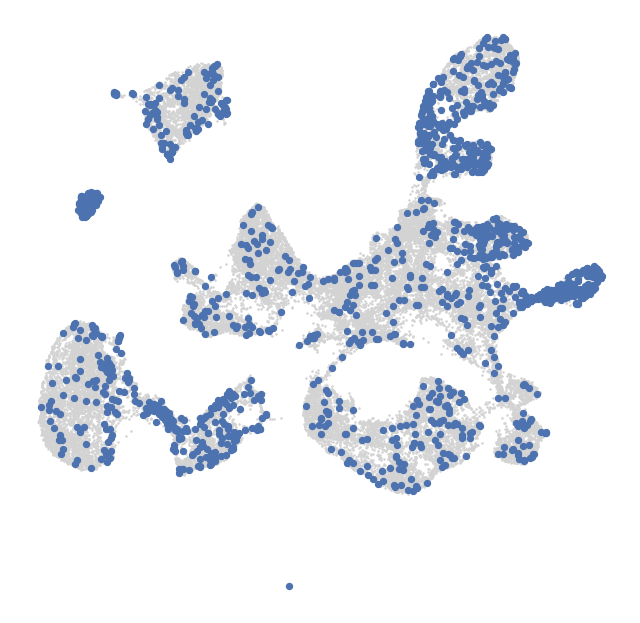

In [20]:
# Plot the initilization to ensure they are evenly spread
SEACells.plot.plot_initialization(ad, model, )

In [34]:
model.fit(n_iter=20)

Randomly initialized A matrix.
Setting convergence threshold at 0.013993257214555209
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 20 iterations.


In [35]:
sc.write(filename = "/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/SEACell_files/rna_sea.h5ad", adata = ad)

AnnData object with n_obs × n_vars = 45991 × 5000
    obs: 'sample', 'stage', 'nFeature_RNA', 'mitochondrial_percent_RNA', 'ribosomal_percent_RNA', 'celltype', '_scvi_batch', '_scvi_labels', 'n_counts', 'SEACell'
    var: 'gene', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

# Accessing results

## Model Convergence

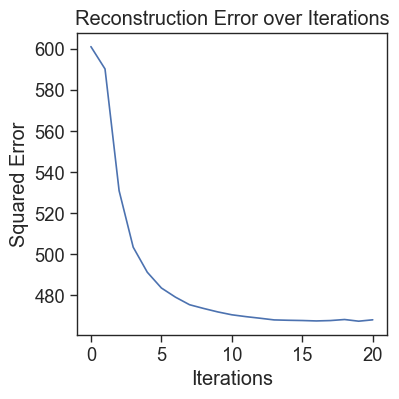

In [19]:
# Check for convergence 
model.plot_convergence()

## SEACell Assignments

These can be accessed as folows:
- in the modified anndata object in `.obs['SEAell']`
- from the model using `.get_assignments()`


In [36]:
ad.obs[['SEACell']].head()

,SEACell
index,
E7.5_rep1#AAACAGCCAGGAACTG-1,E7.5_rep1#GCAAACCGTCCTAACT-1
E7.5_rep1#AAACAGCCATCCTGAA-1,E7.5_rep1#AGCTCATAGGCGAATA-1
E7.5_rep1#AAACAGCCATGCTATG-1,E7.5_rep1#TTGTGCGAGTTCCCAC-1
E7.5_rep1#AAACATGCAACCTGGT-1,E8.0_rep1#GCTTAGTAGTAAACCC-1
E7.5_rep1#AAACATGCAATGAATG-1,E8.0_rep2#TCCTGGTTCCTAATTC-1


In [37]:
model.get_assignments().head()

,SEACell
index,
E7.5_rep1#AAACAGCCAGGAACTG-1,E7.5_rep1#GCAAACCGTCCTAACT-1
E7.5_rep1#AAACAGCCATCCTGAA-1,E7.5_rep1#AGCTCATAGGCGAATA-1
E7.5_rep1#AAACAGCCATGCTATG-1,E7.5_rep1#TTGTGCGAGTTCCCAC-1
E7.5_rep1#AAACATGCAACCTGGT-1,E8.0_rep1#GCTTAGTAGTAAACCC-1
E7.5_rep1#AAACATGCAATGAATG-1,E8.0_rep2#TCCTGGTTCCTAATTC-1


# Summarizing data

- `core.summarize_by_SEACell()`

Datasets can be summarized by SEACell by aggregating cells within each SEACell, summing over all raw data for all cells belonging to a SEACell. The output of this function is an anndata object of shape n_metacells x original_data_dimension. Data is unnormalized and raw aggregated counts are stored in `X`. Attributes associated with variables (.var) are copied over, but relevant per SEACell attributes must be manually copied, since certain attributes may need to be summed, or averaged etc, depending on the attribute.

By default, `ad.raw` is used for summarization. Other layers present in the anndata can be specified using the parameter `summarize_layer` parameter

In [34]:
ad = sc.read(filename = "/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/SEACell_files/rna_sea_aggregates.h5ad")

In [27]:
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='raw')
SEACell_ad

  0%|          | 0/613 [00:00<?, ?it/s]

/omics/groups/OE0533/internal/katharina/seacells_yml/lib/python3.8/site-packages/SEACells/core.py:558: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  meta_ad = sc.AnnData(csr_matrix(summ_matrix))


AnnData object with n_obs × n_vars = 613 × 5000
    layers: 'raw'

In [47]:
#sc.write(filename = "/omics/groups/OE0533/internal/katharina/scDoRI/gastrulation_data/jupyter_notebooks/SEACell_files/rna_sea_aggregates.h5ad", adata = ad)

In [35]:
ad

AnnData object with n_obs × n_vars = 45991 × 5000
    obs: 'sample', 'stage', 'nFeature_RNA', 'mitochondrial_percent_RNA', 'ribosomal_percent_RNA', 'celltype', '_scvi_batch', '_scvi_labels', 'n_counts', 'SEACell'
    var: 'gene', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

AnnData object with n_obs × n_vars = 45991 × 5000
    obs: 'sample', 'stage', 'nFeature_RNA', 'mitochondrial_percent_RNA', 'ribosomal_percent_RNA', 'celltype', '_scvi_batch', '_scvi_labels', 'n_counts', 'SEACell'
    var: 'gene', 'n_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'celltype_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## Normalization

Normalization of metacell data can be performed using the `sc.pp.normalize_total` and `sc.pp.log1p` functions

# Evaluating Results

We provide several methods for evaluating SEACell assignments:

## Visualizing Results

Metacells also implements methods for visualizing the results of the Metacells algorithm 
    <ul> 
        <li>```.plot_2D()``` provides an interface for viewing metacell assignments on any 2-dimensional embedding in ad.obsm. Plots can also be coloured by metacell assignment.
        <li>```.plot_SEACell_sizes()``` can be used to view the distribution of number of cells assigned to each metacell
    </ul>
    
            

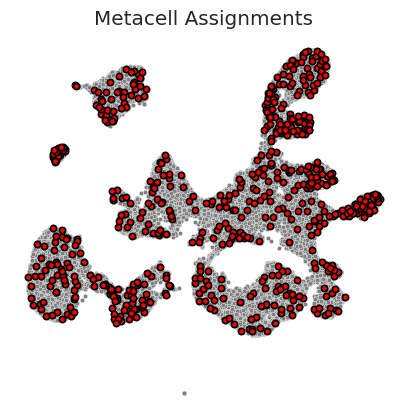

In [39]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=False)

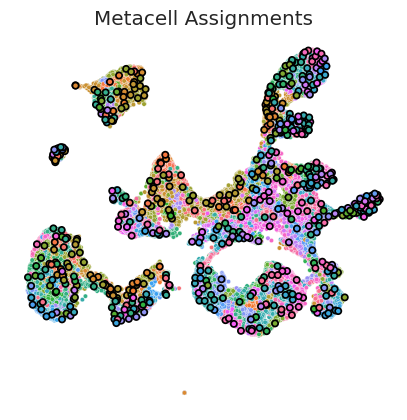

In [40]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

/omics/groups/OE0533/internal/katharina/seacells_yml/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


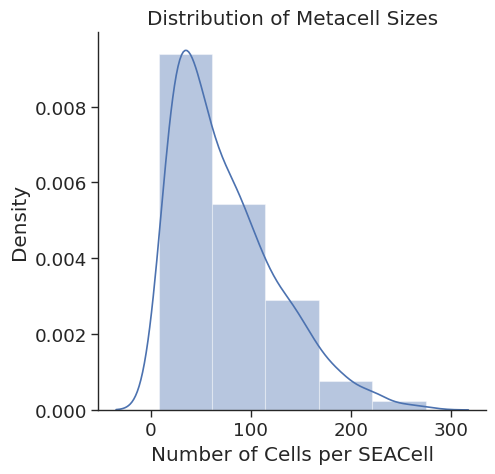

,size
SEACell,
E7.5_rep1#AAAGCCGCACATAGCC-1,60
E7.5_rep1#AAAGGAGCAAGGTGGC-1,57
E7.5_rep1#AACCGCTCATGACTAT-1,162
E7.5_rep1#AACCTCCTCTCACTCA-1,14
E7.5_rep1#AAGAACAGTTGTAACG-1,39
...,...
E8.75_rep2#TGTCATAAGATAGACG-1,78
E8.75_rep2#TGTTGTTTCAAACCGT-1,138
E8.75_rep2#TTAATCGAGTTGGCCA-1,57


In [41]:
SEACells.plot.plot_SEACell_sizes(ad, bins=5)

## Quantifying Results

SEACells also implements methods for visualizing the results of the SEACells algorithm 
    <ul> 
        <li>```.compute_celltype_purity(ad, col_name)``` computes the purity of different celltype labels within a SEACell metacell. Typically, col_name='celltype' or similar. Returns a pd.DataFrame of length n_SEACells.
        <li>```.compactness(ad, low_dim_embedding)``` computes the per-SEAcell variance in diffusion components. ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. Lower values of compactness suggest more compact/lower variance metacells.
        <li>```separation(ad, low_dim_embedding,nth_nbr=1,cluster=None)``` computes the diffusion distance between a SEACell and its ```nth_nbr```. As before, ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. If ```cluster``` is provided as a string, e.g. 'celltype', nearest neighbors are restricted to have the same celltype value.  Higher values of separation suggest better distinction between metacells.
    </ul>
    


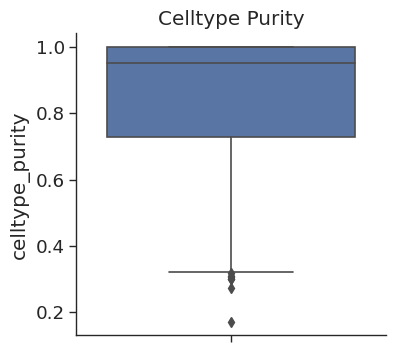

,celltype,celltype_purity
SEACell,,
E7.5_rep1#AAAGCCGCACATAGCC-1,Mesenchyme,0.950000
E7.5_rep1#AAAGGAGCAAGGTGGC-1,ExE_ectoderm,0.877193
E7.5_rep1#AACCGCTCATGACTAT-1,Nascent_mesoderm,0.518519
E7.5_rep1#AACCTCCTCTCACTCA-1,Parietal_endoderm,1.000000
E7.5_rep1#AAGAACAGTTGTAACG-1,ExE_endoderm,0.923077


In [42]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(ad, 'celltype')

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='celltype_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

Determing nearest neighbor graph...


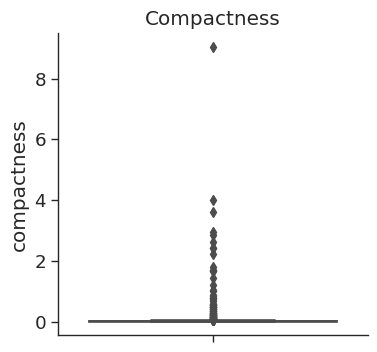

,compactness
SEACell,
E7.5_rep1#AAAGCCGCACATAGCC-1,0.007356
E7.5_rep1#AAAGGAGCAAGGTGGC-1,0.017563
E7.5_rep1#AACCGCTCATGACTAT-1,0.002176
E7.5_rep1#AACCTCCTCTCACTCA-1,0.002740
E7.5_rep1#AAGAACAGTTGTAACG-1,0.223232


In [45]:
compactness = SEACells.evaluate.compactness(ad, 'X_scVI')

plt.figure(figsize=(4,4))
sns.boxplot(data=compactness, y='compactness')
plt.title('Compactness')
sns.despine()
plt.show()
plt.close()

compactness.head()

Determing nearest neighbor graph...


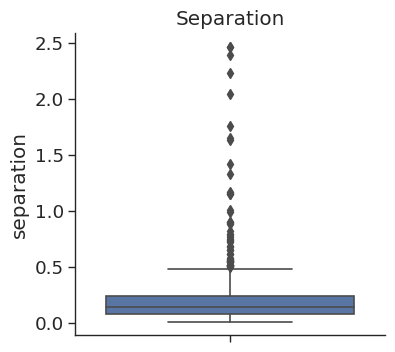

,separation
SEACell,
E7.5_rep1#AAAGCCGCACATAGCC-1,0.186243
E7.5_rep1#AAAGGAGCAAGGTGGC-1,0.227990
E7.5_rep1#AACCGCTCATGACTAT-1,0.160275
E7.5_rep1#AACCTCCTCTCACTCA-1,0.044846
E7.5_rep1#AAGAACAGTTGTAACG-1,0.688627


In [46]:
separation = SEACells.evaluate.separation(ad, 'X_scVI',nth_nbr=1)

plt.figure(figsize=(4,4))
sns.boxplot(data=separation, y='separation')
plt.title('Separation')
sns.despine()
plt.show()
plt.close()

separation.head()

# ATAC

In [36]:
help(SEACells.genescores.prepare_multiome_anndata)

Help on function prepare_multiome_anndata in module SEACells.genescores:

prepare_multiome_anndata(atac_ad, rna_ad, SEACell_label='SEACell', n_bins_for_gc=50)
    Function to create metacell Anndata objects from single-cell Anndata objects
    
    :param atac_ad: (Anndata) ATAC Anndata object with raw peak counts in `X`. These anndata objects should be constructed 
     using the example notebook available in 
    :param rna_ad: (Anndata) RNA Anndata object with raw gene expression counts in `X`. Note: RNA and ATAC anndata objects 
     should contain the same set of cells
    :param SEACell_label: (str) `atac_ad.obs` field for constructing metacell matrices. Same field will be used for 
      summarizing RNA and ATAC metacells. 
    :param n_bins_gc: (int) Number of bins for creating GC bins of ATAC peaks.
    
    :return: ATAC metacell Anndata object and RNA metacell Anndata object



In [33]:
atac_meta_ad, rna_meta_ad = SEACells.genescores.prepare_multiome_anndata(atac, ad, SEACell_label='SEACell')


Generating Metacell matrices...
 ATAC


KeyError: 'SEACell'